In [119]:
import fermat as F
import numpy as np
import scipy.sparse as sp
import time
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

importe lo necesario y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [120]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        
        res+=dist                      
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient


#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    dim=initialData.shape[1]
    assert(initialData.shape[0]*dim==len(x))
    real_x=x.reshape(-1,dim)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dim*i:(i+1)*dim]=local_gradient
    return res,gradient


un ejemplito

In [121]:
data=np.random.random((10,2))

x=np.ones(16)

##Euclidean
print(euclidean_cost(x,data[0:8,:]))

##Fermat

initialData=data[0:8,:]
dimension=2
alpha=2
k=2
f_dist,tree=fermat_graph(data,alpha=alpha)


fermat_cost(x,initialData,dimension,f_dist,tree,data,k,alpha)

(6.796351595977895, array([0.29413304, 0.51864019, 1.59380902, 1.13887767, 0.87889661,
       1.41057949, 1.81438241, 0.15040551, 0.53398595, 0.49108935,
       1.544379  , 1.14739696, 1.79184499, 1.85066973, 1.79931141,
       1.6777042 ]))


(2.635986446676473,
 array([0.29413304, 0.51864019, 0.53398595, 0.49108935, 0.53398595,
        0.49108935, 0.53398595, 0.49108935, 0.53398595, 0.49108935,
        0.53398595, 0.49108935, 0.53398595, 0.49108935, 0.53398595,
        0.49108935]))

Armo aca los datos que podrian servir para al menos probar que ande

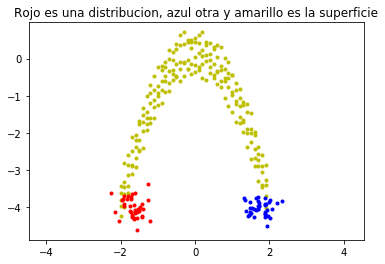

In [122]:
puntos=40

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)


dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)




y1, y2 = np.random.multivariate_normal([1.7,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1.7,-4], [[0.05,0],[0,0.05]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

# ACA ARRANCA LO NUEVO

## Tomo la dist de fermat al cuadrado por lo que dijo esteban, sino cualquier solucion en la geodesica va a ser lo mismo

In [255]:
data=np.concatenate((Zcol,Ycol,W),axis=0)


x=np.concatenate((Zcol,Ycol),axis=0) #los datos X iniciales, las distribuciones. 
z=np.matrix([0 for i in range(Zcol.shape[0])]+[1 for i in range(Ycol.shape[0])]).T
#le pongo label 0 a la primera y 1 a la segunda




alpha=2
k=20
dimension=2
h=np.std(x)*1.06*(x.shape[0]**(-1/5)) #TODO (es el bandwith de los kernel)
f_dist,tree=fermat_graph(data,alpha=alpha)
f_dist=f_dist#**2

#PUSE EL CUADRADO PERO NO CAMBIE EL GRADIENTE!
#(HABRIA QUE REESCALARLO CON UN 2*DIST_FERMAT),NO? TODO


### Defino las funciones que utilizan en el paper de tabak. Basicamente los nucleos y sus gradientes (armo una matriz que tiene el resultado de los kernel con los posibles centros evaluados en  los posibles puntos), esta matriz C que definen, el lagrangiano y su gradiente 

In [256]:
#ARMO LA MATRIZ C    
#vector con los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,1)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C

def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C





#DEFINO LOS KERNEL Y SUS GRADIENTES (DERIVO EN PRIMER COORDENADA)
def kernel2(x,centro):
    return np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 
     
def kernel_grad2(x,centro):
    return -(1/(h**2))*(x-centro)*np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 




#matriz que tieneen el lugar ij al kernel(y_i,y_j) y
#lo mismo con gradiente_ij (en la primer coord derivo el kernel de centro y_j y evaluo en y_i)
#TENGO QUE HACERLO MAS RAPIDO ESTO!!
def kernel_matrix_y2(y):
        y_matrix=np.zeros((y.shape[0],y.shape[0]))
        for i in range(y.shape[0]):
            y_matrix[i,:]=np.array([kernel2(y[i,:],y[j,:])  for j in range(y.shape[0])]).reshape(1,-1)
        return y_matrix
    
def grad_matrix_y2(y):
        grad_matrix=np.zeros((y.shape[0],y.shape[0],dimension))
        for i in range(y.shape[0]):
            for j in range(y.shape[0]):
                grad_matrix[i,j,:]=kernel_grad2(y[i,:],y[j,:])
        return grad_matrix
                
        
        
        
        
#AHORA DEFINO LAGRANGIANO Y SU GRADIENTE                
def lagrangiano(landa,kernel_matrix,C,cost): 
    return  cost+ landa * (kernel_matrix.flatten() @ C.flatten())
#el lagrangiano es: sum_i[ cost(x_i,y_i)+ sum_k[landa*kernel(y_i,y_k)*C_il]   ]
    
    
    
    
    
#el gradiente de la parte de la F del lagrangiano
def fgrad(y,grad_matrix,C): 
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
    return aux




# derivo en y_i
def lagrangiano_grad(landa,cost_grad,f_grad):
    return cost_grad+landa*f_grad






#La cuenta de como actualizar el landamin,hace la cuenta de que desciendo en direccion de L_F (que aca llamo f_grad)
def landamin_actualizacion(cost_grad,f_grad):
    num=cost_grad@f_grad
    denom=f_grad@f_grad
    return num/denom

### Tratando de paralelizar asi no es una tortuga (lo hago principalmente con lo de los kernels y su gradiente que es una cuenta que hago mucho y grande)

In [257]:
import scipy
from scipy.spatial.distance import pdist, squareform

#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y(y):
    pairwise_dists = squareform(pdist(y, 'euclidean'))
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )
    
    

    
def grad_matrix_y(y):
    pairwise_dists=squareform(pdist(y,'euclidean'))
    #armo la matriz que tiene el escalar por el que multiplico a la direccion
    aux=scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension))
    aux=aux*(-1/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) la resta de los y correspondeintes
    #en el lugar ij tendre y_i-y_j y eso luego lo multiplico por aux.
    unos=np.ones((y.shape[0],1))
    res=np.zeros((y.shape[0],y.shape[0],dimension))
    for d in range(dimension):
        res[:,:,d]=(y[:,d].reshape(-1,1)) @unos.T -  unos @ (y[:,d].reshape(-1,1)).T  
        res[:,:,d]=res[:,:,d]*aux
    return res
       

In [258]:
%%time
y=np.random.random((100,dimension))
asd=kernel_matrix_y(y)
asdd=grad_matrix_y(y)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 19.1 ms


In [259]:
%%time 
#VEMOS QUE ESTE TARDA MUCHO MAS, AHORA ES MAS EFICIENTE


asd2=kernel_matrix_y2(y)
asdd2=grad_matrix_y2(y)

CPU times: user 4.82 s, sys: 136 ms, total: 4.96 s
Wall time: 4.85 s


In [260]:
#CHEQUEO QUE EFECTIVAMENTE DE LO MISMO...
print(np.alltrue(asd2-asd<1e19),np.alltrue(asdd2-asdd<1e19))


True True


### El algoritmo que proponen (falta poner bien la formula del landamin que no la hice aun, ver que seria un buen beta y un buen landamax -ademas de una learningrate inicial y un h (el bandwith) inicial-)

In [574]:
#x va a ser los puntos iniciales (distintas distribuciones)
#y van a ser los transportados (baricentro)


niter=3000
learningrate0=1 #TODO 
beta=1  #es el alpha que pone tabak #TODO
landamax=10e4 #TODO
landa0=10#TODO


#y=np.ones(x.shape)
y=x
C=armar_C_categorico(z) #en z pongo fila a fila los distintos valores de z
landa=landa0
learningrate=learningrate0
n=0

while (n<niter):
    learningrate=min(learningrate*2.01,learningrate0)
    
    #cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
    cost,cost_grad=euclidean_cost(y.flatten(),x)
    
    
    grad_matrix=grad_matrix_y(y)
    f_grad=fgrad(y,grad_matrix,C)
    
    kernel_matrix=kernel_matrix_y(y)
    print(cost,(lagrangiano(landa,kernel_matrix,C,cost)-cost)/landa)
    
    
    beta=landa*0.5
    landamin=beta-landamin_actualizacion(cost_grad,f_grad)
    
    
    
    if(landamin>landa and landamin<landamax): 
        landa=landamin
    elif(landamin>landamax): 
        landa=landamax
    
    
    gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
    yviejo=y
    costviejo=cost
    
    
    while(True):
        y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
        kernel_matrix=kernel_matrix_y(y) 
        
        #cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
        cost,cost_grad=euclidean_cost(y.flatten(),x)
       
        lag_nuevo=lagrangiano(landa,kernel_matrix,C,cost)
        lag_viejo=lagrangiano(landa,kernel_matrix,C,costviejo)
        
        if(lag_nuevo<=(1+1/landa)*lag_viejo): 
            break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
        learningrate=learningrate/2             
      
    print("it: "+str(n)+", paso: "+str(learningrate*np.linalg.norm(gradienteLagrangiano))+", landa: "+str(landa))
    n=n+1       

0.0 5.769294371225666
it: 0, paso: 1.7988107921295353, landa: 10
3.2357202658816866 5.017501270939314
it: 1, paso: 0.6102253954206895, landa: 20.495486675271692
5.591513369367049 4.7424671446453885
it: 2, paso: 0.6219172358245032, landa: 29.80189643700313
8.884645119922128 4.439154951164054
it: 3, paso: 0.4651152629224679, landa: 38.97735983160614
11.832727084795085 4.209140499805493
it: 4, paso: 0.30831975051871136, landa: 47.020676751829086
14.012638045340454 4.0560215831365225
it: 5, paso: 0.3746164351839503, landa: 53.38456011983925
16.90580876808057 3.8697449601072975
it: 6, paso: 0.4276936482349969, landa: 59.49096852872879
20.52601392721887 3.657721003781985
it: 7, paso: 0.23895411052663346, landa: 65.98750771545093
22.68535713070927 3.540040268849007
it: 8, paso: 0.26549514906150745, landa: 71.19848785924731
25.205916586685856 3.4098654554948946
it: 9, paso: 0.28666940746896463, landa: 76.0404047230522
28.06556142329895 3.270268886209738
it: 10, paso: 0.30595207119813506, landa

132.41774463525772 0.7809547363689026
it: 87, paso: 0.03358902775590758, landa: 442.1908171019611
132.9715736282132 0.7750526909793295
it: 88, paso: 0.03394751448707651, landa: 447.04756680050093
133.53097219249528 0.7691349974930718
it: 89, paso: 0.03424666901427894, landa: 451.5148528815018
134.09448259755226 0.7632150290299985
it: 90, paso: 0.034517821656243, landa: 455.82054953313934
134.66137329772482 0.7572994668522683
it: 91, paso: 0.03477627812179047, landa: 460.0762669589983
135.2312667571098 0.7513917457701371
it: 92, paso: 0.035029512453536034, landa: 464.33670453175284
135.80395737981695 0.745493724699169
it: 93, paso: 0.035281175861797034, landa: 468.6286942345217
136.37932247048 0.7396064959905172
it: 94, paso: 0.035533054859515176, landa: 472.9654093714718
136.95727869832737 0.733730777182982
it: 95, paso: 0.035786026796474496, landa: 477.35331382919117
137.5377608117473 0.7278671003897208
it: 96, paso: 0.036040525857571934, landa: 481.79555950819224
138.12071123167647 0

178.6849072278732 0.3728797542595578
it: 171, paso: 0.030129776980572443, landa: 876.8673788401381
179.0275842922414 0.3702779145477546
it: 172, paso: 0.030308326798530707, landa: 880.8985346301255
179.37176257251147 0.3676721911970607
it: 173, paso: 0.03048794726706252, landa: 884.9755049718029
179.71747387240583 0.36506259891674225
it: 174, paso: 0.030668645141852368, landa: 889.0999589057128
180.06475077949392 0.3624491554186375
it: 175, paso: 0.03085042719476189, landa: 893.2736358434613
180.4136266681888 0.35983188158647045
it: 176, paso: 0.03103330023255163, landa: 897.4983484570082
180.76413570241425 0.35721080164766067
it: 177, paso: 0.031217271107642212, landa: 901.7759854369783
181.11631283760002 0.35458594334863613
it: 178, paso: 0.031402346725115084, landa: 906.1085142004519
181.47019382176563 0.35195733813410207
it: 179, paso: 0.03158853404802664, landa: 910.4979835861064
181.8258151955095 0.3493250213304286
it: 180, paso: 0.03177584010205724, landa: 914.9465265536248
182.

205.57976101355203 0.20155891585833285
it: 256, paso: 0.024636476017661342, landa: 1375.0673109927375
205.87311829293682 0.20011770880136887
it: 257, paso: 0.02477485499216763, landa: 1383.636885449099
206.1683445319318 0.19867649117695957
it: 258, paso: 0.024914076038279186, landa: 1392.3592276338222
206.46544630375925 0.1972353686738493
it: 259, paso: 0.025054144969941888, landa: 1401.2375209787933
206.76442979076003 0.19579444844648913
it: 260, paso: 0.02519506765241482, landa: 1410.2750109317235
207.06530077006187 0.19435383908497186
it: 261, paso: 0.025336850003687187, landa: 1419.4750055363131
207.3680645990793 0.1929136505824496
it: 262, paso: 0.02547949799599518, landa: 1428.8408759495346
207.67272620085373 0.1914739942999623
it: 263, paso: 0.025623017657443938, landa: 1438.376056888458
207.97929004923392 0.19003498292861087
it: 264, paso: 0.025767415073739634, landa: 1448.0840469984566
208.287760153906 0.18859673044900505
it: 265, paso: 0.025912696390037064, landa: 1457.968409

223.23172292769584 0.12959868692195375
it: 339, paso: 0.019424622809828093, landa: 2110.856851059156
223.45964166149375 0.12883952691596873
it: 340, paso: 0.019530851659218754, landa: 2123.675683598798
223.68850851673628 0.12808086184524636
it: 341, paso: 0.01963770302988748, landa: 2136.6462276327848
223.91831930044503 0.12732272229267028
it: 342, paso: 0.009872590515061406, landa: 2149.769675304624
224.0335969849867 0.1269434688690701
it: 343, paso: 0.00994539616307077, landa: 2159.6798206472995
224.15003369281223 0.1265622462411653
it: 344, paso: 0.010008008079544016, landa: 2168.023512362403
224.26730827490073 0.1261796538624384
it: 345, paso: 0.010065688923441389, landa: 2175.618292374406
224.38526157353306 0.1257959915222995
it: 346, paso: 0.010121061039329735, landa: 2182.8701037270703
224.50381502356262 0.12541141039407383
it: 347, paso: 0.010175430281899548, landa: 2189.9806154158796
224.62293014334267 0.12502598797359207
it: 348, paso: 0.0102294470259254, landa: 2197.05012091

234.77479850741972 0.09518946027469564
it: 421, paso: 0.015033224070174815, landa: 2888.0567919950777
234.93376500360898 0.09476300226753845
it: 422, paso: 0.015113343761481317, landa: 2900.3230528725257
235.0932539133279 0.09433620630994995
it: 423, paso: 0.015193906949970084, landa: 2912.6717002528076
235.2532642204073 0.09390907727849934
it: 424, paso: 0.015274916056789083, landa: 2925.1029841687173
235.41379490812065 0.093481619990041
it: 425, paso: 0.01535637350959792, landa: 2937.6171613257197
235.57484496121054 0.09305383920159255
it: 426, paso: 0.01543828174234845, landa: 2950.2144960708088
235.73641336796828 0.09262573961035106
it: 427, paso: 0.015520643195055287, landa: 2962.8952614163672
235.898499122367 0.09219732585385257
it: 428, paso: 0.015603460313555717, landa: 2975.6597401214476
236.0611012262456 0.09176860251028132
it: 429, paso: 0.01568673554925814, landa: 2988.508225833057
236.22421869154803 0.09133957409893394
it: 430, paso: 0.01577047135887821, landa: 3001.441024

243.54165387729017 0.07310615086000014
it: 503, paso: 0.011547705575146474, landa: 3635.783596378088
243.65013632816022 0.07284926452295729
it: 504, paso: 0.01160787272136979, landa: 3645.94569017273
243.759023509984 0.07259180743303477
it: 505, paso: 0.011668359540012923, landa: 3656.1786496442965
243.86831695809497 0.07233378098701533
it: 506, paso: 0.01172916770023251, landa: 3666.483531063284
243.97801823347794 0.07207518663223411
it: 507, paso: 0.011790298877885633, landa: 3676.861422946283
244.08812892350602 0.07181602586829944
it: 508, paso: 0.011851754755541687, landa: 3687.3134470397786
244.19865064267566 0.07155630024887145
it: 509, paso: 0.011913537022497294, landa: 3697.840759322673
244.30958503333596 0.07129601138349993
it: 510, paso: 0.011975647374794677, landa: 3708.4445510272208
244.42093376641316 0.07103516093952147
it: 511, paso: 0.012038087515243472, landa: 3719.12604967807
244.53269854212644 0.07077375064401757
it: 512, paso: 0.01210085915344662, landa: 3729.8865201

it: 586, paso: 0.008874418965451583, landa: 4461.534368820467
251.10736030677927 0.056213175158524406
it: 587, paso: 0.008919977938248433, landa: 4471.744470809466
251.18456578285463 0.05605275034848201
it: 588, paso: 0.00896577452331662, landa: 4482.051145109517
251.26211591808263 0.05589188018707671
it: 589, paso: 0.009011809984162239, landa: 4492.455765248029
251.3400123244454 0.055730565961294734
it: 590, paso: 0.009058085591297739, landa: 4502.959726183011
251.41825661256462 0.05556880900925138
it: 591, paso: 0.00910460262229652, landa: 4513.564444556135
251.49685039132208 0.05540661072091982
it: 592, paso: 0.009151362361848494, landa: 4524.271358944527
251.57579526745434 0.055243972538863664
it: 593, paso: 0.009198366101816513, landa: 4535.081930111128
251.65509284512683 0.055080895958973565
it: 594, paso: 0.0092456151412939, landa: 4545.997641253305
251.7347447254827 0.05491738253120673
it: 595, paso: 0.009293110786662884, landa: 4557.019998249509
251.81475250616813 0.0547534338

257.12276771593775 0.0445758848889128
it: 668, paso: 0.006761811465733726, landa: 5475.151369465195
257.17841536838785 0.0444766486486518
it: 669, paso: 0.006796245367064979, landa: 5486.530155455801
257.234308449785 0.044377121108222166
it: 670, paso: 0.00683085711598366, landa: 5498.006147322183
257.2904476913286 0.04427730281176439
it: 671, paso: 0.006865647655751969, landa: 5509.580281744413
257.34683380902914 0.04417719432590763
it: 672, paso: 0.006900617934847734, landa: 5521.25350212543
257.4034675034584 0.044076796239857316
it: 673, paso: 0.006935768906999817, landa: 5533.026758535792
257.46034945949066 0.04397610916548088
it: 674, paso: 0.006971101531223509, landa: 5544.901007652781
257.5174803460315 0.043875133737391304
it: 675, paso: 0.00700661677185581, landa: 5556.877212693936
257.574860815737 0.043773870613028384
it: 676, paso: 0.007042315598590902, landa: 5568.956343344887
257.6324915047214 0.04367232047273755
it: 677, paso: 0.007078198986515672, landa: 5581.139375681447

262.45553424874294 0.035675285390254656
it: 752, paso: 0.0051958087879435235, landa: 6810.938223595262
262.49435046615304 0.03561460555414747
it: 753, paso: 0.005222203755949292, landa: 6822.542008323046
262.53331640522435 0.03555373139543978
it: 754, paso: 0.005248694285944436, landa: 6834.1790747432615
262.57243115400695 0.035492663560989665
it: 755, paso: 0.0052753006058740125, landa: 6845.870739565327
262.61169444868807 0.035431402323498694
it: 756, paso: 0.005302033173132049, landa: 6857.627862513702
262.6511063406054 0.0353699477736842
it: 757, paso: 0.0053288975667971, landa: 6869.456097877611
262.69066703 0.035308299916075585
it: 758, paso: 0.005355896931260043, landa: 6881.358509186486
262.730376783084 0.03524645871674122
it: 759, paso: 0.005383033196738638, landa: 6893.336871015468
262.7702358907393 0.035184424127040446
it: 760, paso: 0.005410307688866401, landa: 6905.392317141521
262.81024464801425 0.03512219609541967
it: 761, paso: 0.005437721433147401, landa: 6917.52566326

266.19060861931297 0.029986595718902078
it: 835, paso: 0.007909570615508095, landa: 8072.2455199585975
266.24184132882334 0.029910232183336223
it: 836, paso: 0.007949795837145052, landa: 8091.966427957708
266.2932157613284 0.029833691619603444
it: 837, paso: 0.00799022733730007, landa: 8111.818494654712
266.3447316195271 0.0297569744851982
it: 838, paso: 0.008030866173089686, landa: 8131.802775871003
266.3963886082751 0.029680081243304724
it: 839, paso: 0.008071713407331631, landa: 8151.92033935189
266.448186434898 0.029603012362770447
it: 840, paso: 0.008112770108615424, landa: 8172.172264603934
266.50012480950573 0.02952576831807794
it: 841, paso: 0.00815403735137522, landa: 8192.559642702745
266.5522034453001 0.029448349589314256
it: 842, paso: 0.008195516215964756, landa: 8213.083576069967
266.6044220588823 0.029370756662138096
it: 843, paso: 0.008237207788734414, landa: 8233.745178218205
266.6567803705539 0.02929299002774435
it: 844, paso: 0.008279113162110423, landa: 8254.5455734

269.6391070040573 0.024925025024891842
it: 917, paso: 0.0059968953877900764, landa: 9603.588136730283
269.67223229198856 0.02487723376527022
it: 918, paso: 0.006027203668789979, landa: 9620.184375080953
269.7054726948421 0.024829292655609823
it: 919, paso: 0.006057666369296422, landa: 9636.876871648275
269.73882850518845 0.02478120155309744
it: 920, paso: 0.00608828428880567, landa: 9653.666065095138
269.77230001499805 0.024732960316695512
it: 921, paso: 0.006119058230963037, landa: 9670.552392239792
269.8058875158842 0.024684568807075608
it: 922, paso: 0.006149989003578826, landa: 9687.536288124968
269.8395912993374 0.024636026886553527
it: 923, paso: 0.006181077418643521, landa: 9704.61818609926
269.87341165695557 0.024587334419026843
it: 924, paso: 0.006212324292342263, landa: 9721.798517911691
269.90734888066686 0.02453849126991374
it: 925, paso: 0.006243730445068539, landa: 9739.077713820388
269.94140326295127 0.0244894973060938
it: 926, paso: 0.0062752967014370895, landa: 9756.45

272.8136373648611 0.020437343787646025
it: 1000, paso: 0.00911915415623194, landa: 11356.976580984605
272.85778278421 0.02037673198709117
it: 1001, paso: 0.004582690800456376, landa: 11383.81369603958
272.87991824325286 0.020346333643077242
it: 1002, paso: 0.004608876781421336, landa: 11404.025716639098
272.90225446052415 0.020315783966308967
it: 1003, paso: 0.004633640093866511, landa: 11420.977064569106
272.92473694250754 0.02028510131712618
it: 1004, paso: 0.004657750098126638, landa: 11436.345094804328
272.94733899782693 0.020254294675980417
it: 1005, paso: 0.004681592384908053, landa: 11450.96630339542
272.9700478329723 0.020223368339263057
it: 1006, paso: 0.004705360251504226, landa: 11465.258102824224
272.99285759146517 0.0201923242669863
it: 1007, paso: 0.004729150724207339, landa: 11479.429041266107
273.0157658705454 0.020161163256163368
it: 1008, paso: 0.004753012652177463, landa: 11493.583577333884
273.0387719790499 0.020129885527081722
it: 1009, paso: 0.004776970780844189, 

275.0058142789526 0.017556424831877592
it: 1081, paso: 0.006859732730377763, landa: 12857.606184828735
275.03834266284093 0.017516093845589695
it: 1082, paso: 0.006894305082050033, landa: 12883.120160075923
275.0710439276534 0.017475637427939613
it: 1083, paso: 0.006929051500247212, landa: 12908.907818679385
275.10391958529294 0.01743505580577867
it: 1084, paso: 0.006963972834827076, landa: 12934.974375472597
275.1369711640485 0.01739434922235531
it: 1085, paso: 0.006999069939066285, landa: 12961.325164232936
275.1702002085273 0.01735351793773128
it: 1086, paso: 0.0070343436696580705, landa: 12987.965640419403
275.20360827957063 0.01731256222920584
it: 1087, paso: 0.00706979488670964, landa: 13014.901383977533
275.23719695415525 0.017271482391748028
it: 1088, paso: 0.007105424453739146, landa: 13042.138102213601
275.27096782527934 0.01723027873843672
it: 1089, paso: 0.0071412332376723274, landa: 13069.681632739976
275.30492250183323 0.017188951600909084
it: 1090, paso: 0.00717722210883

277.0820251708445 0.015184709855089453
it: 1162, paso: 0.005156330704022998, landa: 14856.303233112849
277.10755062076294 0.015158243119992063
it: 1163, paso: 0.005182241480120784, landa: 14886.273865852756
277.13321964142796 0.015131694557666907
it: 1164, paso: 0.005208282460385808, landa: 14916.581239075782
277.1590330908943 0.015105064403579395
it: 1165, paso: 0.0052344542901897355, landa: 14947.23048069724
277.18499182791703 0.01507835290358022
it: 1166, paso: 0.005260757617866031, landa: 14978.226810639298
277.21109671175464 0.015051560314079785
it: 1167, paso: 0.005287193094721248, landa: 15009.575542624842
277.2373486019551 0.015024686902224598
it: 1168, paso: 0.005313761375046538, landa: 15041.282086005402
277.2637483581334 0.014997732946076042
it: 1169, paso: 0.005340463116129267, landa: 15073.351947623769
277.2902968397346 0.014970698734791075
it: 1170, paso: 0.005367298978264848, landa: 15105.790733711663
277.31699490578654 0.014943584568805195
it: 1171, paso: 0.005394269624

278.9080872798052 0.013458223240235857
it: 1243, paso: 0.0038741800891084342, landa: 17526.29635285522
278.9279232810331 0.013441244195587662
it: 1244, paso: 0.003893618262624276, landa: 17561.76289770251
278.94785979263395 0.013424214191622036
it: 1245, paso: 0.003913154039353334, landa: 17597.583159180234
278.96789716711544 0.013407133367504796
it: 1246, paso: 0.003932787908453457, landa: 17633.761495341354
278.98803575115977 0.013390001867676459
it: 1247, paso: 0.003952520361547251, landa: 17670.302322276977
279.00827588547656 0.013372819841905486
it: 1248, paso: 0.003972351892741142, landa: 17707.21011474733
279.02861790464056 0.013355587445342515
it: 1249, paso: 0.0039922829986446424, landa: 17744.48940680204
279.04906213691135 0.013338304838576644
it: 1250, paso: 0.004012314178390033, landa: 17782.14479238868
279.0696089040389 0.013320972187691385
it: 1251, paso: 0.0040324459336525285, landa: 17820.180925947963
279.09025852105253 0.013303589664322686
it: 1252, paso: 0.00405267876

280.57269957979514 0.012143842637741405
it: 1324, paso: 0.0029105752886818517, landa: 21252.57938059813
280.5870900403543 0.012133341525692766
it: 1325, paso: 0.0029251663720642365, landa: 21292.02265811697
280.6015378998413 0.012122808643788908
it: 1326, paso: 0.002939830759236258, landa: 21331.779830634874
280.61604319697517 0.012112244030928232
it: 1327, paso: 0.002954568824718267, landa: 21371.853374503975
280.63060595271935 0.012101647728875347
it: 1328, paso: 0.002969380944819956, landa: 21412.245760978738
280.6452261708806 0.01209101978218621
it: 1329, paso: 0.002984267497741956, landa: 21452.95945600638
280.65990383863243 0.012080360238140242
it: 1330, paso: 0.0029992288636414687, landa: 21493.99691969661
280.67463892696276 0.01206966914667855
it: 1331, paso: 0.0030142654246795918, landa: 21535.36060558718
280.6894313910531 0.012058946560348288
it: 1332, paso: 0.003029377565059491, landa: 21577.052959762565
280.7042811705907 0.012048192534252251
it: 1333, paso: 0.00304456567105

281.89826738196984 0.011197464942967349
it: 1405, paso: 0.004365896179213356, landa: 25618.046231408778
281.9157973356215 0.01118470198866544
it: 1406, paso: 0.004387855541892424, landa: 25686.67792485901
281.9333147968163 0.011171916615583916
it: 1407, paso: 0.004409927658465689, landa: 25755.55854490376
281.95081724836683 0.011159108957115152
it: 1408, paso: 0.004432113176662507, landa: 25824.67695230156
281.96830210430085 0.01114627914392754
it: 1409, paso: 0.004454412749048535, landa: 25894.021463972436
281.9857667085987 0.011133427303754594
it: 1410, paso: 0.004476827032997583, landa: 25963.579839158934
282.00320833393687 0.011120553561178593
it: 1411, paso: 0.004499356690654974, landa: 26033.339265727984
282.0206241804465 0.011107658037408017
it: 1412, paso: 0.004522002388891165, landa: 26103.286346663048
282.03801137448175 0.011094740850048815
it: 1413, paso: 0.004544764799245142, landa: 26173.407086798503
282.05536696740927 0.01108180211287009
it: 1414, paso: 0.0045676445978570

it: 1485, paso: 0.0016086366134043743, landa: 30832.331734815656
281.93369754753274 0.00855393726111887
it: 1486, paso: 0.001600867534311995, landa: 31455.214408288535
281.9451546171335 0.008549924768986993
it: 1487, paso: 0.0016034369006440907, landa: 32186.225131352337
281.9563287187087 0.008546022437561033
it: 1488, paso: 0.0016108943501506614, landa: 32947.726661623
281.96728206608964 0.008542206166739008
it: 1489, paso: 0.0016207426852921985, landa: 33699.66004401821
281.97799535879165 0.008538463061295685
it: 1490, paso: 0.0016317983082030389, landa: 34420.18865462164
281.9884158366298 0.00853478514693807
it: 1491, paso: 0.0016434680028920882, landa: 35096.82200142254
281.99848061285576 0.0085311666212877
it: 1492, paso: 0.0016554270300786378, landa: 35722.37552613731
282.00812844447034 0.008527602659860006
it: 1493, paso: 0.0016674768645950988, landa: 36293.11505580756
282.0173058628175 0.008524088905194472
it: 1494, paso: 0.0016794837151194114, landa: 36807.84449144564
282.0259

274.5813561589283 0.0858407097242318
it: 1567, paso: 0.010185054539938608, landa: 59971.463244613245
274.6368224048745 0.08433226799564336
it: 1568, paso: 0.01014050993400008, landa: 59971.463244613245
274.69220838667826 0.08284445215847364
it: 1569, paso: 0.010095563301589224, landa: 59971.463244613245
274.74750956879876 0.08137715347697312
it: 1570, paso: 0.010050219803641075, landa: 59971.463244613245
274.8027214300842 0.07993026045034983
it: 1571, paso: 0.010004484670880422, landa: 59971.463244613245
274.85783946491694 0.07850365886822418
it: 1572, paso: 0.009958363202476735, landa: 59971.463244613245
274.9128591843562 0.07709723186687797
it: 1573, paso: 0.009911860764681467, landa: 59971.463244613245
274.96777611727293 0.0757108599862587
it: 1574, paso: 0.009864982789448477, landa: 59971.463244613245
275.0225858114799 0.07434442122769927
it: 1575, paso: 0.009817734773038253, landa: 59971.463244613245
275.07728383485284 0.0729977911123147
it: 1576, paso: 0.009770122274606706, landa

277.55272924896303 0.027989448121821386
it: 1648, paso: 0.003973195853324715, landa: 59971.463244613245
277.5774007038335 0.027682171577229252
it: 1649, paso: 0.003963829586342376, landa: 59971.463244613245
277.60203615847536 0.027377862682445877
it: 1650, paso: 0.003954332641203982, landa: 59971.463244613245
277.62663460386227 0.027076516003022678
it: 1651, paso: 0.003944705336684893, landa: 59971.463244613245
277.65119503040427 0.026778125811886988
it: 1652, paso: 0.0039349480080468815, landa: 59971.463244613245
277.67571642808554 0.02648268609075908
it: 1653, paso: 0.003925061007103257, landa: 59971.463244613245
277.70019778660463 0.02619019053164239
it: 1654, paso: 0.003915044702281201, landa: 59971.463244613245
277.7246380955144 0.025900632538386273
it: 1655, paso: 0.003904899478681252, landa: 59971.463244613245
277.7490363443649 0.02561400522832109
it: 1656, paso: 0.0038946257381338545, landa: 59971.463244613245
277.77339152284605 0.02533030143396589
it: 1657, paso: 0.00388422389

278.9550140204514 0.014347579608249016
it: 1728, paso: 0.001750559916164319, landa: 59971.463244613245
278.96638810627246 0.014267294430682101
it: 1729, paso: 0.0017496203604101227, landa: 59971.463244613245
278.9777596827952 0.014187493310247854
it: 1730, paso: 0.0017486323939175025, landa: 59971.463244613245
278.98912841915075 0.014108177748386517
it: 1731, paso: 0.001747595856711154, landa: 59971.463244613245
279.0004939829391 0.014029349205063664
it: 1732, paso: 0.0017465105922880957, landa: 59971.463244613245
279.0118560402519 0.013951009098477817
it: 1733, paso: 0.0017453764476723116, landa: 59971.463244613245
279.0232142556961 0.013873158804775264
it: 1734, paso: 0.0017441932734694437, landa: 59971.463244613245
279.0345682924162 0.013795799657770887
it: 1735, paso: 0.0017429609239214858, landa: 59971.463244613245
279.04591781211917 0.013718932948676533
it: 1736, paso: 0.0017416792569615012, landa: 59971.463244613245
279.05726247509887 0.013642559925836047
it: 1737, paso: 0.00174

it: 1807, paso: 0.0015209500282388605, landa: 59971.463244613245
279.82808528048184 0.009507477250504891
it: 1808, paso: 0.0015160468049062903, landa: 59971.463244613245
279.8381338846465 0.00946698400931035
it: 1809, paso: 0.0015110972900290202, landa: 59971.463244613245
279.84815123735007 0.00942695290032432
it: 1810, paso: 0.001506101747595608, landa: 59971.463244613245
279.8581369928104 0.00938738188502711
it: 1811, paso: 0.0015010604483259953, landa: 59971.463244613245
279.86809080685003 0.00934826888825804
it: 1812, paso: 0.0014959736696816817, landa: 59971.463244613245
279.878012336948 0.009309611798670715
it: 1813, paso: 0.0014908416958746254, landa: 59971.463244613245
279.8879012422915 0.00927140846919767
it: 1814, paso: 0.0014856648178749234, landa: 59971.463244613245
279.89775718382697 0.009233656717522949
it: 1815, paso: 0.0014804433334172542, landa: 59971.463244613245
279.9075798243123 0.009196354326563383
it: 1816, paso: 0.0014751775470060362, landa: 59971.463244613245
27

280.51523758364743 0.007503867115998412
it: 1889, paso: 0.0010001140311278404, landa: 59971.463244613245
280.52185502610877 0.0074920016362812385
it: 1890, paso: 0.000992868880560607, landa: 59971.463244613245
280.52842260361786 0.007480363347652212
it: 1891, paso: 0.0009856199820133431, landa: 59971.463244613245
280.53494025200575 0.0074689491627664304
it: 1892, paso: 0.0009783680661716789, landa: 59971.463244613245
280.54140791197847 0.007457756006684712
it: 1893, paso: 0.0009711138669588703, landa: 59971.463244613245
280.54782552912934 0.0074467808173916215
it: 1894, paso: 0.0009638581214551594, landa: 59971.463244613245
280.5541930539521 0.007436020546306096
it: 1895, paso: 0.0009566015698172423, landa: 59971.463244613245
280.56051044185057 0.007425472158783598
it: 1896, paso: 0.0009493449551979021, landa: 59971.463244613245
280.5667776531489 0.00741513263460972
it: 1897, paso: 0.0009420890236659018, landa: 59971.463244613245
280.5729946531 0.007404998968485934
it: 1898, paso: 0.00

280.65255951621344 0.006407784238409744
it: 1971, paso: 0.004856441733293765, landa: 59971.463244613245
280.6630769108153 0.006401975069613072
it: 1972, paso: 0.009155542321569565, landa: 60499.595241760006
280.6638937753991 0.006392091179534083
it: 1973, paso: 0.018327495892965312, landa: 61330.01907651989
280.63260695068715 0.006373421911117281
it: 1974, paso: 0.037002762509632525, landa: 61862.10614812649
280.59523427160593 0.006335346700032609
it: 1975, paso: 0.07561064845267146, landa: 61862.10614812649
280.3430606281614 0.006281625417027512
it: 1976, paso: 0.0013328210116248574, landa: 61862.10614812649
280.3515925459768 0.006278187849342185
it: 1977, paso: 0.0012533032392465576, landa: 61862.10614812649
280.3593844427636 0.006275151498720487
it: 1978, paso: 0.0011809074586199625, landa: 61862.10614812649
280.3664881572868 0.0062724594477871695
it: 1979, paso: 0.0011152301518716466, landa: 61862.10614812649
280.37295216663193 0.006270062659853852
it: 1980, paso: 0.001055881886650

it: 2051, paso: 0.0015500621406170235, landa: 62408.27472495773
279.830113958642 0.005822202423986556
it: 2052, paso: 0.0014688827591556866, landa: 62408.27472495773
279.8369946332241 0.005819358571352192
it: 2053, paso: 0.0014026134060372791, landa: 62408.27472495773
279.8430398606503 0.005816776046756705
it: 2054, paso: 0.00134927757799651, landa: 62408.27472495773
279.84834268033757 0.005814398879156414
it: 2055, paso: 0.0026140443748102734, landa: 62408.27472495773
279.8576334568189 0.0058100324092598375
it: 2056, paso: 0.0024777788680591176, landa: 62408.27472495773
279.8645384081618 0.005806131068227312
it: 2057, paso: 0.00480183697122083, landa: 62408.27472495773
279.87472556947324 0.005798956974224935
it: 2058, paso: 0.009300571689327545, landa: 62408.27472495773
279.8840017614871 0.005785702962599197
it: 2059, paso: 0.018564863346884498, landa: 62408.27472495773
279.88026439821635 0.0057596356526003365
it: 2060, paso: 0.03796113236198898, landa: 62408.27472495773
279.877016626

it: 2131, paso: 0.0021424394052980394, landa: 62408.27472495773
280.3780423058805 0.005040195999382872
it: 2132, paso: 0.0021532707907804616, landa: 62408.27472495773
280.38302943648046 0.005036153038373546
it: 2133, paso: 0.0021641258504777636, landa: 62408.27472495773
280.3880607591803 0.005032088953974509
it: 2134, paso: 0.0021750038363051397, landa: 62408.27472495773
280.39313651366933 0.005028003753682132
it: 2135, paso: 0.0021859039813998666, landa: 62408.27472495773
280.39825693698924 0.005023897448350316
it: 2136, paso: 0.0021968254999519075, landa: 62408.27472495773
280.40342226332695 0.0050197700522631025
it: 2137, paso: 0.0022077675870407756, landa: 62408.27472495773
280.40863272381307 0.005015621583206927
it: 2138, paso: 0.0022187294184790995, landa: 62408.27472495773
280.41388854632555 0.005011452062543142
it: 2139, paso: 0.002229710150662968, landa: 62408.27472495773
280.4191899552934 0.0050072615152803
it: 2140, paso: 0.0022407089204298705, landa: 62408.27472495773
280.4

it: 2213, paso: 0.0030093893756387435, landa: 62408.27472495773
280.94470545178876 0.004646852353587875
it: 2214, paso: 0.003018045349414345, landa: 62408.27472495773
280.9535083144533 0.004641507992973042
it: 2215, paso: 0.0030266094655724855, landa: 62408.27472495773
280.9623469353369 0.004636159142589888
it: 2216, paso: 0.0030350802039927393, landa: 62408.27472495773
280.9712205848658 0.004630806217146928
it: 2217, paso: 0.003043456069941937, landa: 62408.27472495773
280.9801285118858 0.0046254496346286615
it: 2218, paso: 0.0030517355955535863, landa: 62408.27472495773
280.9890699435152 0.00462008981612991
it: 2219, paso: 0.0030599173413181817, landa: 62408.27472495773
280.9980440850071 0.004614727185685107
it: 2220, paso: 0.0030679998975831737, landa: 62408.27472495773
281.0070501196193 0.00460936217009306
it: 2221, paso: 0.003075981886060996, landa: 62408.27472495773
281.0160872084925 0.004603995198736783
it: 2222, paso: 0.0030838619613439513, landa: 62408.27472495773
281.02515449

it: 2293, paso: 0.0019369672074398146, landa: 62408.27472495773
281.3865938866525 0.0043947668274297875
it: 2294, paso: 0.0019420980762534451, landa: 62408.27472495773
281.3920681437474 0.004391778621517909
it: 2295, paso: 0.001947209798666706, landa: 62408.27472495773
281.3975457076436 0.00438878957464976
it: 2296, paso: 0.0019523021994264226, landa: 62408.27472495773
281.4030261675712 0.004385799794250002
it: 2297, paso: 0.0019573751109266116, landa: 62408.27472495773
281.40850910636834 0.004382809387852116
it: 2298, paso: 0.0019624283734293946, landa: 62408.27472495773
281.41399410046176 0.004379818463069397
it: 2299, paso: 0.0019674618352875403, landa: 62408.27472495773
281.4194807198463 0.00437682712756587
it: 2300, paso: 0.001972475353167963, landa: 62408.27472495773
281.42496852806823 0.004373835489026687
it: 2301, paso: 0.001977468792276411, landa: 62408.27472495773
281.4304570822093 0.004370843655128208
it: 2302, paso: 0.0019824420265829997, landa: 62408.27472495773
281.435945

281.8370712458959 0.004127295378798658
it: 2376, paso: 0.004451710699435851, landa: 62408.27472495773
281.8432715251084 0.00412219666269506
it: 2377, paso: 0.0044470535930543655, landa: 62408.27472495773
281.8492313427159 0.00411714009242166
it: 2378, paso: 0.004442649952213693, landa: 62408.27472495773
281.8549482810098 0.004112124955495723
it: 2379, paso: 0.004438512204644654, landa: 62408.27472495773
281.8604200111992 0.0041071505212075575
it: 2380, paso: 0.004434652704635363, landa: 62408.27472495773
281.8656442944395 0.004102216041151986
it: 2381, paso: 0.004439776318780321, landa: 62526.632915934904
281.87091173947965 0.004097302132564077
it: 2382, paso: 0.004453564434436819, landa: 62760.04421045071
281.8764219417541 0.004092392948900612
it: 2383, paso: 0.004471707481812522, landa: 63050.75276222031
281.8821961539332 0.004087483135171733
it: 2384, paso: 0.0044920774660712325, landa: 63370.135881364586
281.88820955333836 0.0040825711291343145
it: 2385, paso: 0.004513622937422007,

it: 2456, paso: 0.0005848527444164264, landa: 73793.85512363029
281.98307956713563 0.003419591036499467
it: 2457, paso: 0.0005851739770318323, landa: 73793.85512363029
281.98689717868655 0.003418721890186698
it: 2458, paso: 0.0011716477054897992, landa: 73793.85512363029
281.99410414034554 0.0034170017136996786
it: 2459, paso: 0.0011698651946583385, landa: 73793.85512363029
282.00046558886663 0.0034153152607896667
it: 2460, paso: 0.0011701141970270124, landa: 73793.85512363029
282.006086310355 0.003413654692489157
it: 2461, paso: 0.0011719456627906015, landa: 73793.85512363029
282.01105878194875 0.003412013658005555
it: 2462, paso: 0.0011750069638481167, landa: 73793.85512363029
282.01546455748104 0.0034103869905299745
it: 2463, paso: 0.0011790230185905997, landa: 73793.85512363029
282.0193755047756 0.003408770467578351
it: 2464, paso: 0.002367560837866638, landa: 73793.85512363029
282.026337117027 0.0034055516048688648
it: 2465, paso: 0.002377542953427317, landa: 73793.85512363029
282

282.4022488762818 0.0029745307056586673
it: 2538, paso: 0.0019038136347354262, landa: 73793.85512363029
282.4056823255478 0.0029717271132767946
it: 2539, paso: 0.0019127953707894277, landa: 73793.85512363029
282.4091425330716 0.002968910793152416
it: 2540, paso: 0.0019217907314558473, landa: 73793.85512363029
282.41262955945024 0.002966081772607481
it: 2541, paso: 0.001930799089763322, landa: 73793.85512363029
282.41614346335126 0.0029632400810652004
it: 2542, paso: 0.001939819805976208, landa: 73793.85512363029
282.4196843010473 0.0029603857500937847
it: 2543, paso: 0.0019488522275330467, landa: 73793.85512363029
282.42325212601355 0.0029575188134485352
it: 2544, paso: 0.0019578956889902536, landa: 73793.85512363029
282.42684698856965 0.002954639307112568
it: 2545, paso: 0.0019669495119713715, landa: 73793.85512363029
282.43046893556414 0.0029517472693360827
it: 2546, paso: 0.001976013005122108, landa: 73793.85512363029
282.434118010088 0.0029488427406745748
it: 2547, paso: 0.00198508

it: 2618, paso: 0.0025945840175329404, landa: 73793.85512363029
282.76287188620665 0.002712838439272289
it: 2619, paso: 0.002601728242307604, landa: 73793.85512363029
282.7681240657009 0.0027093197405638294
it: 2620, paso: 0.0026088046791765524, landa: 73793.85512363029
282.7733831467038 0.00270579940925995
it: 2621, paso: 0.0026158122906537254, landa: 73793.85512363029
282.7786483724456 0.002702277693029343
it: 2622, paso: 0.0026227500562321735, landa: 73793.85512363029
282.7839189693406 0.002698754841168047
it: 2623, paso: 0.002629616973299838, landa: 73793.85512363029
282.78919414689454 0.002695231104514397
it: 2624, paso: 0.002636412058063978, landa: 73793.85512363029
282.7944730976152 0.0026917067353617883
it: 2625, paso: 0.002643134346483441, landa: 73793.85512363029
282.7997549969323 0.0026881819873691717
it: 2626, paso: 0.0026497828952082867, landa: 73793.85512363029
282.8050390031217 0.0026846571154694045
it: 2627, paso: 0.0026563567825263696, landa: 73793.85512363029
282.8103

it: 2699, paso: 0.010767725164110046, landa: 74619.5776391841
283.1453481844867 0.002382027198102414
it: 2700, paso: 0.02158407295006968, landa: 75663.31395441077
283.15124696887506 0.0023632513528561846
it: 2701, paso: 0.010742388857881568, landa: 77464.9989587423
283.1551737029793 0.002354106493252792
it: 2702, paso: 0.010836761724444255, landa: 79002.02852559355
283.16086182731766 0.00234498321019357
it: 2703, paso: 0.005456002524782564, landa: 80413.69611151928
283.1637845936004 0.002340442073449012
it: 2704, paso: 0.005510703808321764, landa: 81438.07069657178
283.1678103384068 0.0023358646042250385
it: 2705, paso: 0.005552002343478251, landa: 82273.70717753089
283.1719149613945 0.0023312872493777333
it: 2706, paso: 0.00558686116163848, landa: 83014.07603053488
283.1760691617426 0.0023267157916668627
it: 2707, paso: 0.005618614643702694, landa: 83705.50073369662
283.1802527334625 0.0023221529301973225
it: 2708, paso: 0.005648936078496284, landa: 84370.51144306481
283.1844432151153

it: 2781, paso: 0.002662578403125338, landa: 94355.94824489192
282.8460721049308 0.002021827554914426
it: 2782, paso: 0.005342557651652845, landa: 94355.94824489192
282.84890860867023 0.002016814884899708
it: 2783, paso: 0.01079727653111822, landa: 94355.94824489192
282.83860826567087 0.0020069036227051184
it: 2784, paso: 0.02206468698850919, landa: 94355.94824489192
282.81047379063637 0.001986271292248612
it: 2785, paso: 0.04588330924419099, landa: 94355.94824489192
282.7878467891226 0.0019402896995047633
it: 2786, paso: 0.09935814939631393, landa: 94355.94824489192
282.5087743471006 0.0018406190449871164
it: 2787, paso: 0.00016779965825273782, landa: 94355.94824489192
282.5117842150298 0.0018402519476041072
it: 2788, paso: 0.00016735654705414354, landa: 94355.94824489192
282.5147677523364 0.0018398884999502908
it: 2789, paso: 0.00016692483390472432, landa: 94355.94824489192
282.5177249928028 0.0018395286331455284
it: 2790, paso: 0.00016650469734896597, landa: 94355.94824489192
282.52

it: 2862, paso: 0.005655669841232833, landa: 94355.94824489192
282.7590949751017 0.0017442046851719527
it: 2863, paso: 0.005724919990656626, landa: 94355.94824489192
282.7636813277081 0.0017364992484655201
it: 2864, paso: 0.0028975560039546343, landa: 94355.94824489192
282.766118879429 0.0017325759708706654
it: 2865, paso: 0.002922594127162271, landa: 94355.94824489192
282.7686416368351 0.0017286032602664577
it: 2866, paso: 0.0029478842489561665, landa: 94355.94824489192
282.77125128021004 0.0017245803998542913
it: 2867, paso: 0.0029734281960411106, landa: 94355.94824489192
282.77394954085185 0.0017205066636677639
it: 2868, paso: 0.002999227751261422, landa: 94355.94824489192
282.77673819414673 0.0017163813167874417
it: 2869, paso: 0.0030252846499302134, landa: 94355.94824489192
282.7796190548309 0.0017122036155215313
it: 2870, paso: 0.0030516005759948965, landa: 94355.94824489192
282.78259397377445 0.0017079728075674572
it: 2871, paso: 0.0030781771580298306, landa: 94355.94824489192
2

it: 2943, paso: 0.0012850254944891215, landa: 94355.94824489192
283.0190242893402 0.0014738253623098323
it: 2944, paso: 0.0012927616073773545, landa: 94355.94824489192
283.02168749479233 0.001471703177613852
it: 2945, paso: 0.0013005457065261082, landa: 94355.94824489192
283.024377409422 0.001469565875437144
it: 2946, paso: 0.001308378018040368, landa: 94355.94824489192
283.0270943094461 0.0014674133431906691
it: 2947, paso: 0.001316258766260035, landa: 94355.94824489192
283.02983847379 0.001465245467681268
it: 2948, paso: 0.0013241881736562485, landa: 94355.94824489192
283.03261018409927 0.001463062135118553
it: 2949, paso: 0.0013321664607250574, landa: 94355.94824489192
283.03540972475054 0.0014608632311221984
it: 2950, paso: 0.0013401938458779523, landa: 94355.94824489192
283.03823738286326 0.0014586486407298406
it: 2951, paso: 0.0013482705453295779, landa: 94355.94824489192
283.04109344831033 0.0014564182484050638
it: 2952, paso: 0.0013563967729823805, landa: 94355.94824489192
283.

Veamos que quedo.... Rojo y azul son las dos distribuciones, amarillo los puntos de la superficie. En cruces  vemos el resultado del algoritmo (A donde fue a parar cada punto)

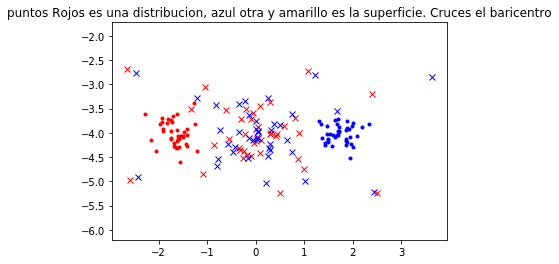

In [575]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

## Aca use y=x como inicial, beta=landa*0.4, lag_nuevo<=(1+0.01/landa)*lag_viejo, niter=100000, learningrate0=1,beta=1 inicial, landamax=10e4, landa0=10

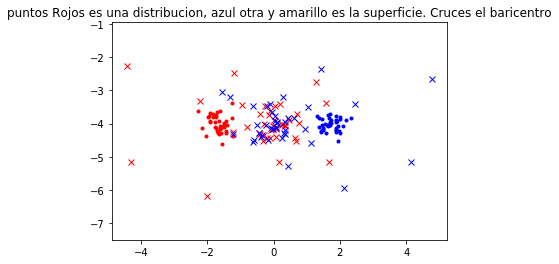

In [554]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

Probando un poco que ande le algoritmo y descienda bien la parte de la f

[ 0.00078002  0.          0.00079181  0.         -0.00079181  0.
 -0.00078002  0.        ]


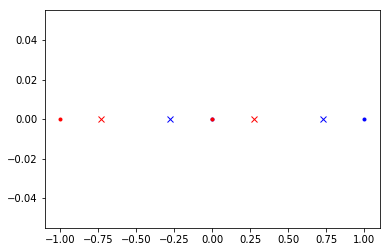

In [118]:
yy=np.array([[1,0],[0,0],[0,0],[-1,0]])
yy_init=yy
zz=np.array([1,1,2,2]).T

for i in range(500):
    C2=armar_C_categorico(zz)
    grad_matrix2=grad_matrix_y(yy)
    f_grad=fgrad(yy,grad_matrix2,C2)
    if (i==0): print(f_grad)

    yy=yy.flatten()-f_grad
    yy=yy.reshape(-1,2)

plt.plot(yy_init[:2,0],yy_init[:2,1],'.',c='b')
plt.plot(yy_init[2:,0],yy_init[2:,1],'.',c='r')
plt.plot(yy[:2,0],yy[:2,1],'x',c='b')
plt.plot(yy[2:,0],yy[2:,1],'x',c='r')
plt.show()
    

# Ignorar, son pruebas de aca para abajo

esto dio con 10.000 iteraciones

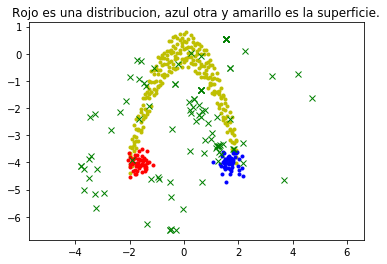

In [67]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:,0],y[:,1],'x',c='g')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie.')
plt.show()

Esto dio con 500 iteraciones, va queriendo...

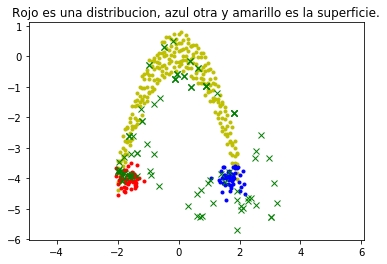

In [64]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:,0],y[:,1],'x',c='g')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie.')
plt.show()

In [68]:
hice10000=y

In [154]:
def kernel_matrix_y(y):
    def fu(i,j):
        return kernel(y[i,:],y[j,:])
    f=np.vectorize(fu)
    return np.fromfunction(f,(y.shape[0],y.shape[0]),dtype=int)  
    
    
def grad_matrix_y(y):
    def fu2(i,j,d):
        return kernel_grad(y[i,:],y[j,:])[d]
    f2=np.vectorize(fu2)
    return np.fromfunction(f2,(y.shape[0],y.shape[0],dimension),dtype=int)  